In [1]:
import os

# Set cuda device to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,2"

# do not prealocate memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_theme(context='paper', style='white', font_scale=1.6, color_codes=True)

In [3]:
import jax.numpy as jnp
import equinox as eqx
from copy import deepcopy
from math import prod
from jax import random, nn, vmap, devices, device_put

from bmr4pml.models import SVIRegression, BMRRegression
from bmr4pml.nn import MLP, LeNet, resnet18, resnet34, resnet50, mish
from bmr4pml.datasets import load_data
from bmr4pml.inference import fit_and_test

rng_key = random.PRNGKey(0)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [4]:
def standardize(train_images, test_images, num_channels=1):
    mean = train_images.reshape(-1, num_channels).mean(0)
    std = train_images.reshape(-1, num_channels).std(0)

    return (train_images - mean) / std, (test_images - mean) / std

def run_inference(rng_key, nnet, opts_regression, opts_fitting, train_ds, test_ds, reg_model=SVIRegression):

    reg = reg_model(
        nnet,
        **opts_regression
    )

    rng_key, opts_fitting['key'] = random.split(rng_key)
    return fit_and_test(reg, train_ds, test_ds, opts_fitting)

def plot_performance(results, num_epochs):
    fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharex=True)

    for key in results:
        vals = results[key]
        if vals is not None:
            for ax, lbl in zip(axes, ['acc', 'ece', 'nll']):
                ax.plot(range(1, num_epochs + 1), vals[lbl], 'o:', label=key)
                ax.set_xlabel('epoch')
                ax.set_title(lbl)

    axes[0].legend(title='method', fontsize=12)
    axes[0].set_ylim([.7, 1.])
    fig.tight_layout()

    return fig

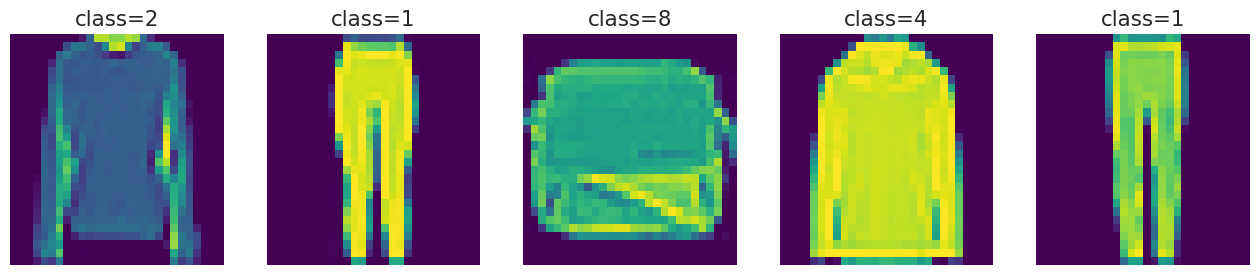

In [5]:
# load data
train_ds, test_ds = load_data('fashion_mnist', platform='gpu', id=0)

in_size = train_ds['image'].shape[-3:]
out_size = len(jnp.unique(train_ds['label']))

fig, axes = plt.subplots(1, 5, figsize=(16, 3), sharex=True, sharey=True)
for n in range(5):
    sns.heatmap(
        train_ds['image'][n].squeeze() / 255, 
        cmap='viridis', 
        ax = axes[n], 
        cbar=False, 
        vmax=1., 
        vmin=0.,
        xticklabels="",
        yticklabels=""
    )
    axes[n].set_title('class={}'.format(train_ds['label'][n]))

train_ds['image'], test_ds['image'] = standardize(train_ds['image'], test_ds['image'], num_channels=1)

# DenseNet

In [6]:
depth = 5
num_neurons = 500
num_epochs = 5
num_iters = 80_000

cpu = devices('cpu')[0]
# results = device_put( jnp.load('../results/fashion_mnist.npz', allow_pickle=True)['results'].item(), cpu )
results = {'dense': {}, 'lenet': {}, 'vit': {}}

In [7]:
opts_regression = {
    'regtype': 'multinomial',
    'gamma0': 0.05,
    'autoguide': 'delta',
    'optim_kwargs': {
        'learning_rate': 1e-4
    }
}

opts_fitting = {
    'num_epochs': num_epochs,
    'num_iters': num_iters,
    'num_samples': 1,
    'model_kwargs': {
        'batch_size': 512, 
        'with_hyperprior': False,
    }
}

rng_key, key = random.split(rng_key)
dense = MLP( prod(in_size), out_size, num_neurons, depth, activation=nn.swish, dropout_rate=0.5, key=key)

100%|██████████| 5/5 [05:23<00:00, 64.60s/it, init loss: 1504906.0000, avg. loss [epoch 5]: 1304473.1250]


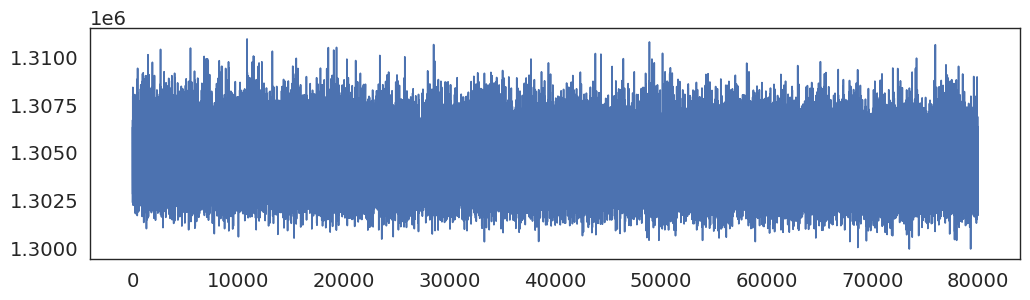

In [17]:
rng_key, key = random.split(rng_key)
output = run_inference(key, dense, opts_regression, opts_fitting, train_ds, test_ds, reg_model=SVIRegression)
results['dense']['Flat-MAP'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])

100%|██████████| 5/5 [07:38<00:00, 91.74s/it, init loss: 4486510.5000, avg. loss [epoch 5]: 45059.7344] 


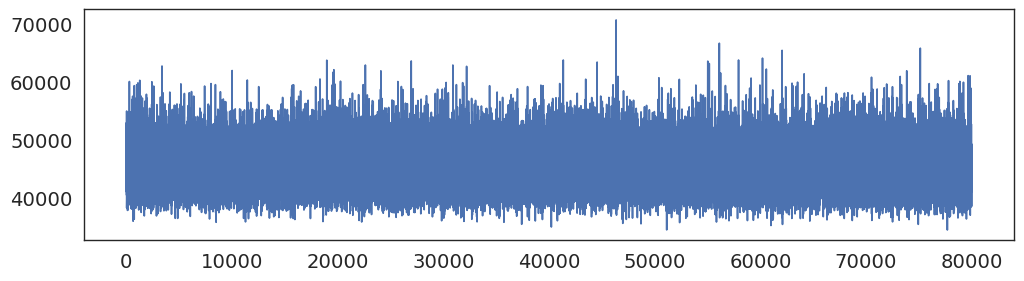

In [26]:
opts_regression = opts_regression | {'gamma0': 0.05, 'autoguide': 'mean-field', 'optim_kwargs': {'learning_rate': 1e-3}}
opts_fitting = opts_fitting | {'num_samples': 100}

dense = eqx.tree_inference(dense, value=True)

rng_key, key = random.split(rng_key)
output = run_inference(key, dense, opts_regression, opts_fitting, train_ds, test_ds, reg_model=SVIRegression)
results['dense']['Flat-FF'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])

In [8]:
opts_regression = opts_regression | {'gamma0': 0.05, 'autoguide': 'structured', 'optim_kwargs': {'learning_rate': 1e-3}}
opts_fitting = opts_fitting | {'num_samples': 100}

dense = eqx.tree_inference(dense, value=True)

rng_key, key = random.split(rng_key)
output = run_inference(key, dense, opts_regression, opts_fitting, train_ds, test_ds, reg_model=SVIRegression)
results['dense']['Flat-STR'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])

 20%|██        | 1/5 [09:55<39:40, 595.25s/it, init loss: 56246476.0000, avg. loss [epoch 1]: 230572.2344]

100%|██████████| 5/5 [13:15<00:00, 159.15s/it, init loss: 3623816.7500, avg. loss [epoch 5]: 32189.9160]


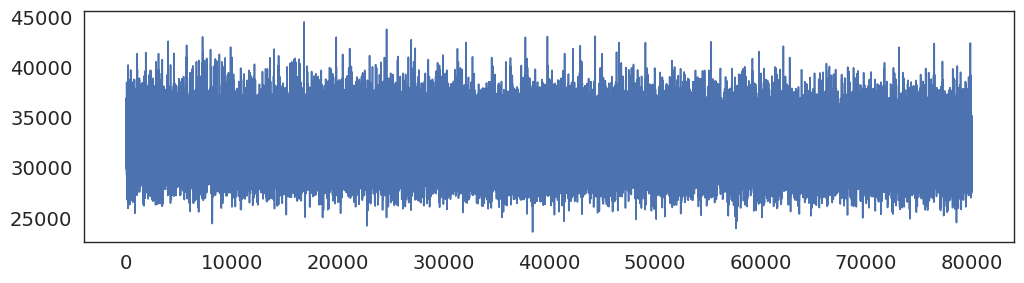

In [28]:
opts_regression = opts_regression | {'tau0': 1e-2, 'reduced': True, 'autoguide': 'mean-field', 'optim_kwargs': {'learning_rate': 1e-3}}
opts_fitting = opts_fitting | {'num_samples': 100, 'model_kwargs': {'batch_size': 512, 'with_hyperprior': True}}

dense = eqx.tree_inference(dense, value=True)

rng_key, key = random.split(rng_key)
output = run_inference(key, dense, opts_regression, opts_fitting, train_ds, test_ds, reg_model=SVIRegression)
results['dense']['Tiered-FF'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])

In [8]:
opts_regression = opts_regression | {'tau0': 1e-2, 'reduced': True, 'autoguide': 'structured', 'optim_kwargs': {'learning_rate': 1e-3}}
opts_fitting = opts_fitting | {'num_samples': 100, 'model_kwargs': {'batch_size': 512, 'with_hyperprior': True}}

dense = eqx.tree_inference(dense, value=True)

rng_key, key = random.split(rng_key)
output = run_inference(key, dense, opts_regression, opts_fitting, train_ds, test_ds, reg_model=SVIRegression)
results['dense']['Tiered-STR'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])

 20%|██        | 1/5 [11:02<44:11, 662.83s/it, init loss: 5914605.5000, avg. loss [epoch 1]: 165052.4219]

In [8]:
opts_regression = {
    'regtype': 'multinomial',
    'gamma0': 0.05,
    'pruning': 'spike-and-slab',
    'posterior': 'normal',
    'optim_kwargs': {
        'learning_rate': 1e-3
    }
}

opts_fitting = {
    'num_epochs': num_epochs,
    'num_iters': num_iters - 10_000,
    'num_samples': 100,
    'model_kwargs': {
        'batch_size': 512, 
        'with_hyperprior': False,
    }
}

dense = eqx.tree_inference(dense, value=True)

rng_key, key = random.split(rng_key)
state, params = run_inference(key, dense, opts_regression, opts_fitting | {'warmup_iters': 400_000}, train_ds, test_ds, reg_model=BMRRegression)

100%|██████████| 5/5 [09:45<00:00, 117.03s/it, init loss: 905884.1250, avg. loss [epoch 5]: 29742.4258]


[0.0127224  0.964155   0.9726202  0.97586346 0.9771475 ]
[0.84779996 0.84209996 0.84139997 0.8452     0.84779996]


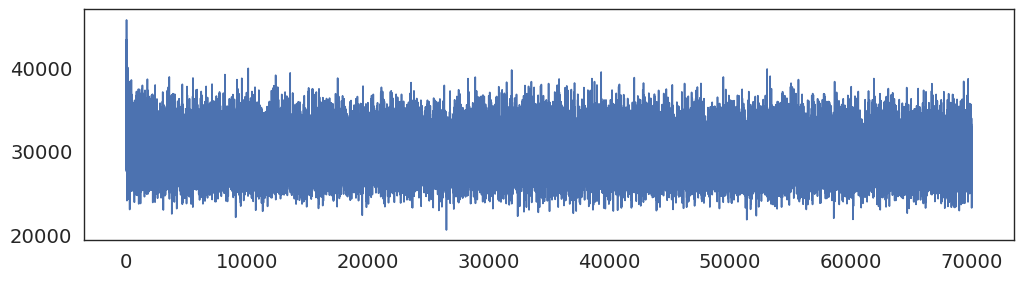

In [9]:
opts_fitting = opts_fitting | {'state': deepcopy(state), 'params': deepcopy(params)}
opts_regression = opts_regression | {'tau0': 1e-2, 'reduced': True,  'pruning': 'regularised-horseshoe'}
opts_fitting = opts_fitting | {'pruning_kwargs': {'delta': 1e-5}}

rng_key, key = random.split(rng_key)
output = run_inference(key, dense, opts_regression, opts_fitting, train_ds, test_ds, reg_model=BMRRegression)
results['dense']['BMR-RHS'] = output
print(output['zip'])
print(output['acc'])

plt.figure( figsize=(12, 3) )
plt.plot( output['losses'][-1] )

In [10]:
opts_fitting = opts_fitting | {'state': deepcopy(state), 'params': deepcopy(params)}
opts_regression = opts_regression | {'pruning': 'spike-and-slab'}

rng_key, key = random.split(rng_key)
output = run_inference(key, dense, opts_regression, opts_fitting, train_ds, test_ds, reg_model=BMRRegression)
results['dense']['BMR-S&S'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])

 60%|██████    | 3/5 [04:56<03:18, 99.11s/it, init loss: 41189.8516, avg. loss [epoch 3]: 29607.1484]

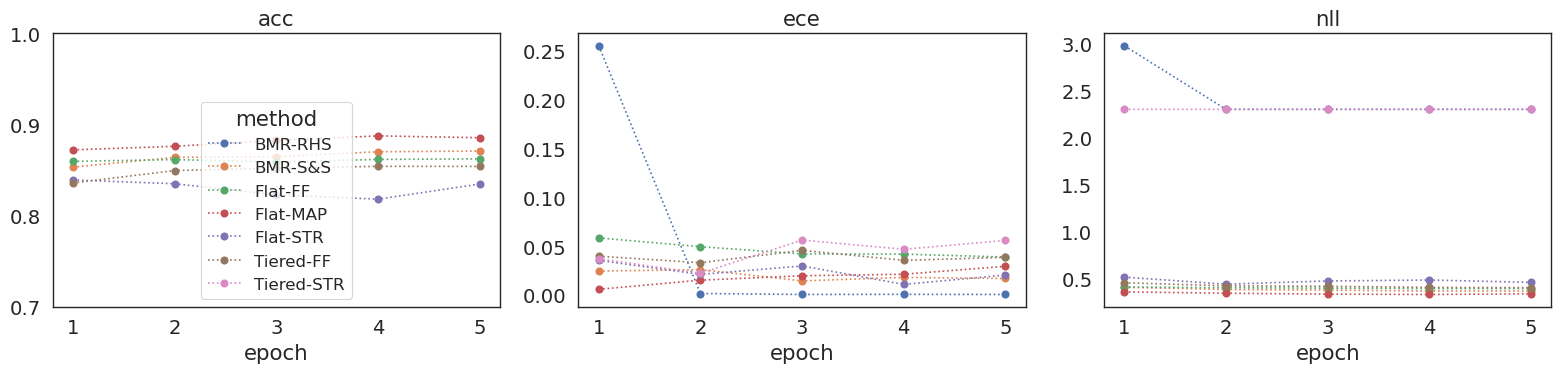

In [17]:
plot_performance( results['dense'], num_epochs );

## LeNet

In [6]:
num_epochs = 5
num_iters = 80_000

train_ds['image'] = jnp.pad(train_ds['image'].transpose(0, 3, 1, 2), ((0, 0), (0, 0), (2, 2), (2, 2)))
test_ds['image'] = jnp.pad(test_ds['image'].transpose(0, 3, 1, 2), ((0, 0), (0, 0), (2, 2), (2, 2)))

in_size = train_ds['image'].shape[-3:]

print(in_size)

(1, 32, 32)


In [21]:
opts_regression = {
    'regtype': 'multinomial',
    'gamma0': 0.05,
    'autoguide': 'delta',
    'optim_kwargs': {
        'learning_rate': 1e-4
    }
}

opts_fitting = {
    'num_epochs': num_epochs,
    'num_iters': num_iters,
    'num_samples': 1,
    'model_kwargs': {
        'batch_size': 512, 
        'with_hyperprior': False
    }
}

rng_key, key = random.split(rng_key)
lenet = LeNet(in_size, activation=nn.swish, dropout_rate=0.5, key=key)

100%|██████████| 5/5 [08:39<00:00, 103.91s/it, init loss: 199041.8125, avg. loss [epoch 5]: 81669.4062]


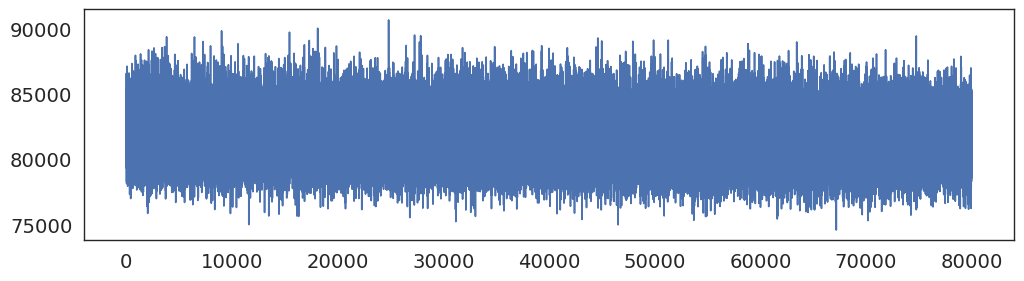

In [10]:
rng_key, key = random.split(rng_key)
output = run_inference(key, lenet, opts_regression, opts_fitting, train_ds, test_ds, reg_model=SVIRegression)
results['lenet']['Flat-MAP'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])

In [ ]:
opts_regression = opts_regression | {'autoguide': 'mean-field', 'optim_kwargs': {'learning_rate': 1e-3}}
opts_fitting = opts_fitting | {'num_samples': 100, 'model_kwargs': {'batch_size': 512, 'with_hyperprior': False}}

lenet = eqx.tree_inference(lenet, value=True)

output = run_inference(key, lenet, opts_regression, opts_fitting, train_ds, test_ds, reg_model=SVIRegression)
results['lenet']['Flat-FF'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])

100%|██████████| 5/5 [21:58<00:00, 263.73s/it, init loss: 429217.5000, avg. loss [epoch 5]: 23250.0039]


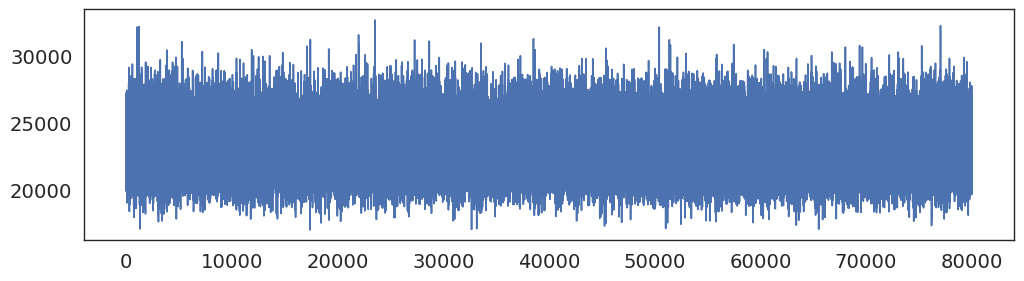

In [10]:
opts_regression = opts_regression | {'autoguide': 'structured', 'optim_kwargs': {'learning_rate': 1e-3}}
opts_fitting = opts_fitting | {'num_samples': 100, 'model_kwargs': {'batch_size': 512, 'with_hyperprior': False}}

lenet = eqx.tree_inference(lenet, value=True)

output = run_inference(key, lenet, opts_regression, opts_fitting, train_ds, test_ds, reg_model=SVIRegression)
results['lenet']['Flat-STR'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])

In [22]:
opts_regression = opts_regression | {'tau0': 5 * 1e-2, 'reduced': True, 'autoguide': 'mean-field', 'optim_kwargs': {'learning_rate': 1e-3}}
opts_fitting = opts_fitting | {'num_samples': 100, 'model_kwargs': {'batch_size': 512, 'with_hyperprior': True}}

lenet = eqx.tree_inference(lenet, value=True)

output = run_inference(key, lenet, opts_regression, opts_fitting, train_ds, test_ds, reg_model=SVIRegression)
results['lenet']['Tiered-FF'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])lenet

 20%|██        | 1/5 [02:22<09:30, 142.73s/it, init loss: 297572.3438, avg. loss [epoch 1]: 33113.1523]

100%|██████████| 5/5 [24:44<00:00, 296.99s/it, init loss: 394434.7500, avg. loss [epoch 5]: 20140.5918]


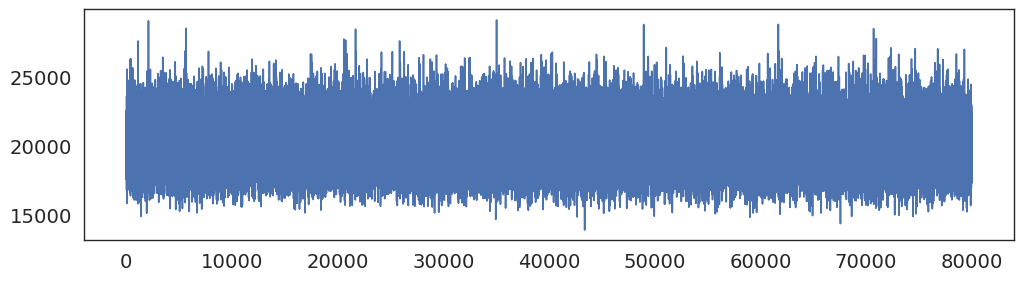

In [12]:
opts_regression = opts_regression | {'tau0': 1e-1, 'reduced': True, 'autoguide': 'structured', 'optim_kwargs': {'learning_rate': 1e-3}}
opts_fitting = opts_fitting | {'num_samples': 100, 'model_kwargs': {'batch_size': 512, 'with_hyperprior': True}}

output = run_inference(key, lenet, opts_regression, opts_fitting, train_ds, test_ds, reg_model=SVIRegression)
results['lenet']['Tiered-STR'] = output
jnp.savez('tmp_results.npz', results=results)

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])

In [ ]:
opts_regression = {
    'regtype': 'multinomial',
    'gamma0': 0.05,
    'pruning': 'spike-and-slab',
    'posterior': 'normal',
    'optim_kwargs': {
        'learning_rate': 1e-3
    }
}

opts_fitting = {
    'num_epochs': num_epochs,
    'num_iters': num_iters - 10_000,
    'num_samples': 100,
    'model_kwargs': {
        'batch_size': 512, 
        'with_hyperprior': False,
    }
}

lenet = eqx.tree_inference(lenet, value=True)

rng_key, key = random.split(rng_key)
state, params = run_inference(key, lenet, opts_regression, opts_fitting | {'warmup_iters': 400_000}, train_ds, test_ds, reg_model=BMRRegression)

In [ ]:
opts_fitting = opts_fitting | {'state': deepcopy(state), 'params': deepcopy(params)}
opts_regression = opts_regression | {'tau0': 5 * 1e-2, 'reduced': True,  'pruning': 'regularised-horseshoe'}
opts_fitting = opts_fitting | {'pruning_kwargs': {'delta': 1e-5}}

rng_key, key = random.split(rng_key)
output = run_inference(key, lenet, opts_regression, opts_fitting, train_ds, test_ds, reg_model=BMRRegression)
results['lenet']['BMR-RHS'] = output
print(output['zip'])
print(output['acc'])

plt.figure( figsize=(12, 3) )
plt.plot( output['losses'][-1] )

100%|██████████| 5/5 [08:04<00:00, 96.84s/it, init loss: 28764.2754, avg. loss [epoch 5]: 25343.2930]


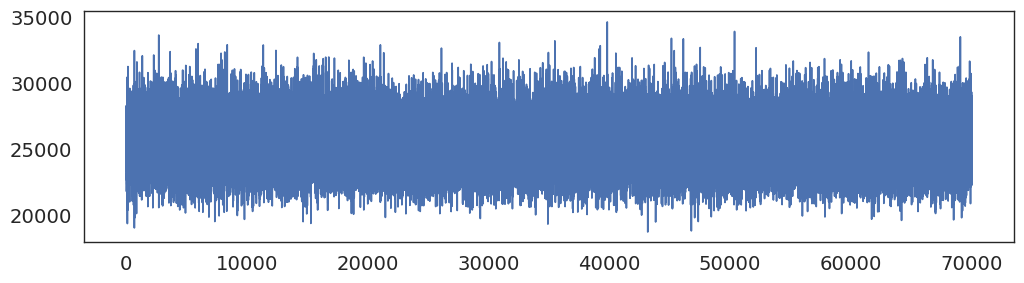

In [14]:
opts_fitting = opts_fitting | {'state': deepcopy(state), 'params': deepcopy(params)}
opts_regression = opts_regression | {'pruning': 'spike-and-slab'}

rng_key, key = random.split(rng_key)
output = run_inference(key, lenet, opts_regression, opts_fitting, train_ds, test_ds, reg_model=BMRRegression)
results['lenet']['BMR-S&S'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])

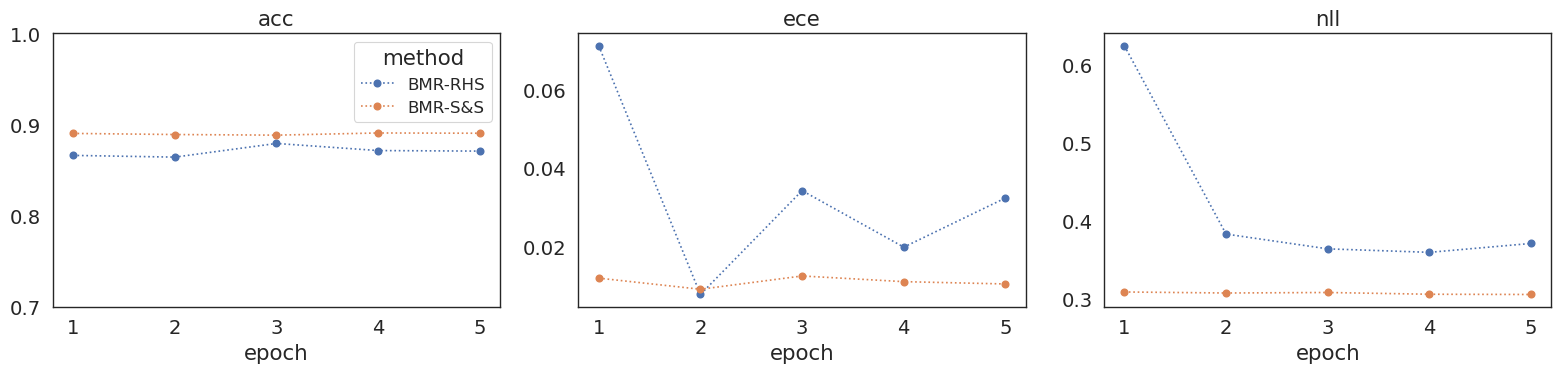

In [17]:
plot_performance( results['lenet'], num_epochs );

# ViT

In [9]:
import eqxvision.models as models

results = jnp.load('../results/fashion_mnist.npz', allow_pickle=True)['results'].item()
results['vit'] = results.pop('vit', {})

num_epochs = 5
num_iters = 80_000

train_ds['image'] = jnp.pad(train_ds['image'].transpose(0, 3, 1, 2), ((0, 0), (0, 0), (2, 2), (2, 2)))
test_ds['image'] = jnp.pad(test_ds['image'].transpose(0, 3, 1, 2), ((0, 0), (0, 0), (2, 2), (2, 2)))

in_size = train_ds['image'].shape[-3:]

print(in_size)

rng_key, key = random.split(rng_key)
vit = models.VisionTransformer(
    img_size = in_size[1],
    patch_size = 8,
    in_chans = in_size[0],
    num_classes = out_size,
    embed_dim = 192,
    depth = 12,
    num_heads = 3,
    drop_rate = 0.0,
    attn_drop_rate = 0.0,
    drop_path_rate = 0.0,
    key = key
)

opts_regression = {
    'regtype': 'multinomial',
    'gamma0': 0.1,
    'autoguide': 'delta',
    'optim_kwargs': {
        'learning_rate': 1e-4
    }
}

opts_fitting = {
    'num_epochs': num_epochs,
    'num_iters': num_iters,
    'num_samples': 1,
    'model_kwargs': {
        'batch_size': 512, 
        'with_hyperprior': False,
    }
}

(1, 32, 32)


In [10]:
rng_key, key = random.split(rng_key)
output = run_inference(key, vit, opts_regression, opts_fitting, train_ds, test_ds, reg_model=SVIRegression)
results['vit']['Flat-MAP'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
plot_performance( results['vit'], num_epochs );

# ResNet

In [8]:
try:
    results = jnp.load('tmp_results.npz', allow_pickle=True)['results'].item()
    results['resnet'] = results.pop('resnet', {})
except:
    results = {'lenet': {}, 'dense': {}, 'resnet': {}}

num_epochs = 5
num_iters = 80_000

# train_ds['image'] = jnp.pad(train_ds['image'].transpose(0, 3, 1, 2), ((0, 0), (0, 0), (2, 2), (2, 2)))
# test_ds['image'] = jnp.pad(test_ds['image'].transpose(0, 3, 1, 2), ((0, 0), (0, 0), (2, 2), (2, 2)))

in_size = train_ds['image'].shape[-3:]

print(in_size)

(1, 32, 32)


In [9]:
opts_regression = {
    'regtype': 'multinomial',
    'gamma0': 0.1,
    'autoguide': 'delta',
    'optim_kwargs': {
        'learning_rate': 1e-4
    }
}

opts_fitting = {
    'num_epochs': num_epochs,
    'num_iters': num_iters,
    'num_samples': 1,
    'model_kwargs': {
        'batch_size': 512, 
        'with_hyperprior': False,
    }
}

rng_key, key = random.split(rng_key)
resnet = resnet18(num_channels=1, num_classes=out_size, activation=nn.swish, key=key)

In [ ]:
rng_key, key = random.split(rng_key)
output = run_inference(key, resnet, opts_regression, opts_fitting, train_ds, test_ds, reg_model=SVIRegression)
results['resnet']['Flat-MAP'] = output
jnp.savez('tmp_results.npz', results=results)

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])

In [10]:
method_opts_reg = {
    'Flat-FF': {'autoguide': 'mean-field', 'optim_kwargs': {'learning_rate': 1e-3}},
    'Flat-STR': {'autoguide': 'structured', 'optim_kwargs': {'learning_rate': 1e-3}},
    'Tiered-FF': {'tau0': 1e-1, 'reduced': True, 'autoguide': 'mean-field', 'optim_kwargs': {'learning_rate': 1e-3}},
    'Tiered-STR': {'tau0': 1e-1, 'reduced': True, 'autoguide': 'structured', 'optim_kwargs': {'learning_rate': 1e-3}}
}

method_opts_fit = {
    'Flat-FF': {'num_samples': 100, 'model_kwargs': {'batch_size': 512, 'with_hyperprior': False}},
    'Flat-STR': {'num_samples': 100, 'model_kwargs': {'batch_size': 512, 'with_hyperprior': False}},
    'Tiered-FF': {'num_samples': 100, 'model_kwargs': {'batch_size': 512, 'with_hyperprior': True}},
    'Tiered-STR': {'num_samples': 100, 'model_kwargs': {'batch_size': 512, 'with_hyperprior': True}}
}

for method in ['Flat-FF', 'Flat-STR', 'Tiered-FF', 'Tiered-STR']:
    opts_regression = opts_regression | method_opts_reg[method]
    opts_fitting = opts_fitting | method_opts_fit[method]

    output = run_inference(key, resnet, opts_regression, opts_fitting, train_ds, test_ds, reg_model=SVIRegression)
    results['resnet'][method] = output
    jnp.savez('tmp_results.npz', results=results)

    plt.figure(figsize=(12, 3))
    plt.plot(output['losses'][-1])

2023-07-24 15:54:01.894954: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reverse.6 = f32[512,512,3,3]{3,2,1,0} reverse(f32[512,512,3,3]{3,2,1,0} %constant.4), dimensions={2,3}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2023-07-24 15:54:02.727704: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.832850018s
Constant folding an instruction is taking > 1s:

  %reverse.6 = f32[512,512,3,3]{3,2,1,0} reverse(f32[512,512,3,3]{3,2,1,0} %constant.4), dimensions={2,3}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilat

In [12]:
 method_opts_reg = {
    'BMR-S&S':  {
    'gamma0': 0.1, 
    'pruning': 'spike-and-slab', 
    'posterior': 'normal', 
    'optim_kwargs': {
            'learning_rate': 1e-3
        },
    },
    
    'BMR-RHS': {'tau0': 1e-1, 'reduced': True, 'pruning': 'regularised-horseshoe'}
}

for method in ['BMR-S&S', 'BMR-RHS']:
    opts_regression = opts_regression | method_opts_reg[method]
    opts_fitting = opts_fitting | {'num_samples': 100, 'model_kwargs': {'batch_size': 512, 'with_hyperprior': False}}

    rng_key, key = random.split(rng_key)
    output = run_inference(key, resnet, opts_regression, opts_fitting, train_ds, test_ds, reg_model=BMRRegression)
    results['resnet'][method] = output
    jnp.savez('tmp_results.npz', results=results)

    plt.figure( figsize=(12, 3) )
    plt.plot( output['losses'][-1] )

2023-07-24 09:23:42.338731: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reverse.6 = f32[512,512,3,3]{3,2,1,0} reverse(f32[512,512,3,3]{3,2,1,0} %constant.4), dimensions={2,3}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2023-07-24 09:23:42.728193: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.389533865s
Constant folding an instruction is taking > 1s:

  %reverse.6 = f32[512,512,3,3]{3,2,1,0} reverse(f32[512,512,3,3]{3,2,1,0} %constant.4), dimensions={2,3}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilat

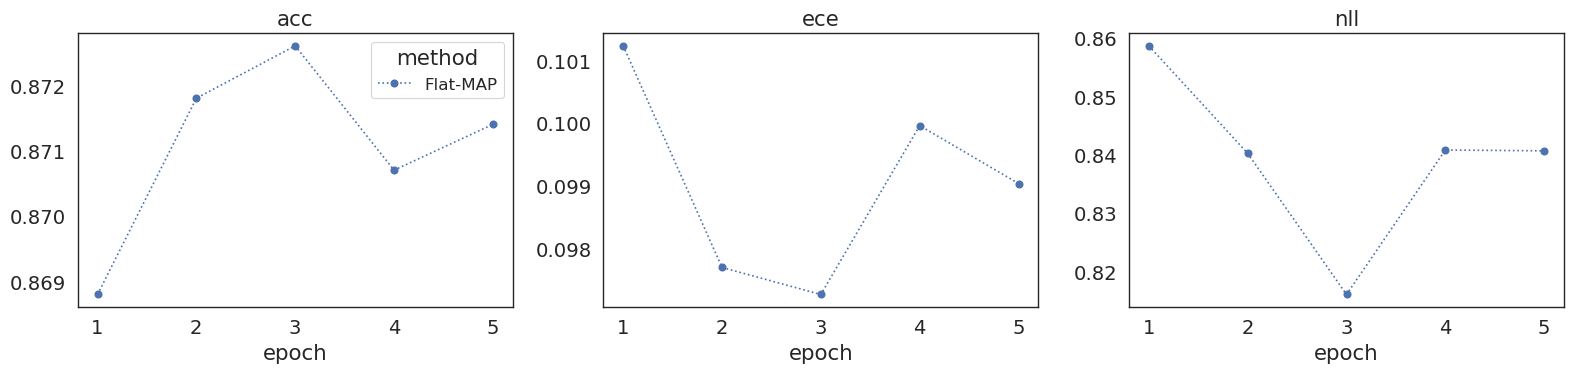

In [12]:
plot_performance( results['resnet'], num_epochs );

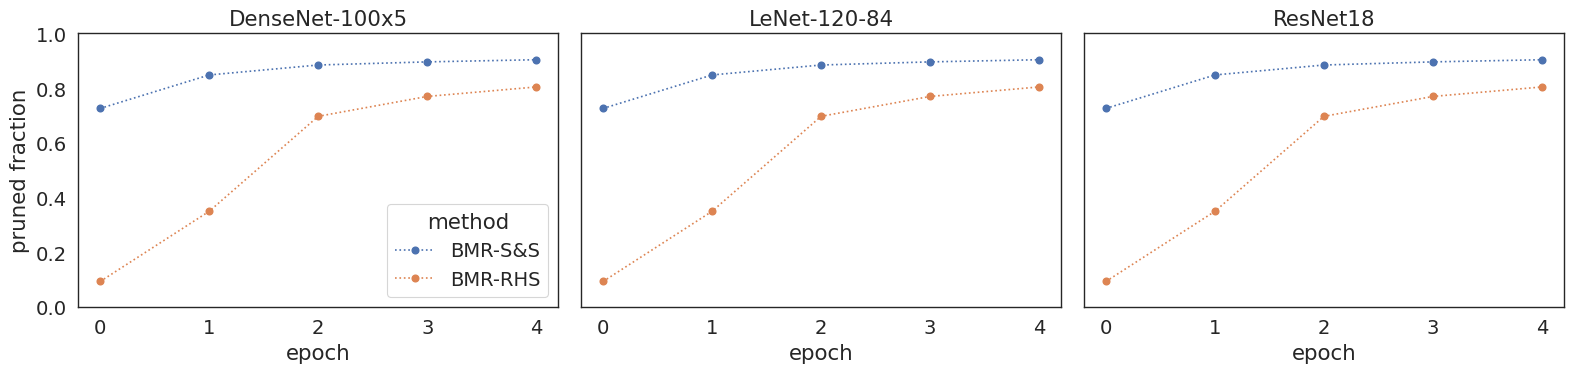

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharex=True, sharey=True)

for i, label in enumerate(['dense', 'lenet', 'resnet']):
    for key in results['dense']:
        vals = results['dense'][key]
        try:
            axes[i].plot(range(num_epochs), vals['zip'], 'o:', label=key)
        except:
            pass

for ax in axes:
    ax.set_xlabel('epoch')

axes[0].set_ylabel('pruned fraction')
axes[0].set_ylim([0, 1])
axes[0].set_title('DenseNet-100x5')
axes[1].set_title('LeNet-120-84')
axes[2].set_title('ResNet18')


axes[0].legend(title='method')
fig.tight_layout()

# CIFAR10

(3, 36, 36) 10


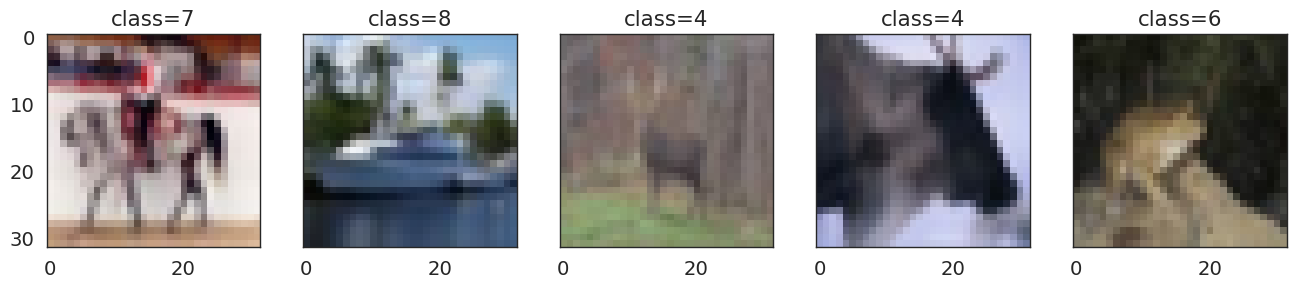

In [ ]:
# load data
cif10_train_ds, cif10_test_ds = load_data('cifar10', platform='gpu', id=0)

fig, axes = plt.subplots(1, 5, figsize=(16, 3), sharex=True, sharey=True)
for n in range(5):
    axes[n].imshow(cif10_train_ds['image'][n]/255)
    axes[n].set_title('class={}'.format(cif10_train_ds['label'][n]))

cif10_train_ds['image'], cif10_test_ds['image'] = standardize(cif10_train_ds['image'], cif10_test_ds['image'], num_channels=3)

cif10_train_ds['image'] = jnp.pad(cif10_train_ds['image'].transpose(0, 3, 1, 2), ((0, 0), (0, 0), (2, 2), (2, 2)))
cif10_test_ds['image'] = jnp.pad(cif10_test_ds['image'].transpose(0, 3, 1, 2), ((0, 0), (0, 0), (2, 2), (2, 2)))

in_size_cif10 = cif10_train_ds['image'].shape[-3:]
out_size_cif10 = len(jnp.unique(cif10_train_ds['label']))

print(in_size_cif10, out_size_cif10)

In [ ]:
try:
    results_cifar10 = jnp.load('tmp_cifar10_results.npz', allow_pickle=True)['results'].item()
except:
    results_cifar10 = {
        'Flat-MAP': None, 
        'Flat-FF': None, 
        'Flat-STR': None,
        'Tiered-FF': None,
        'Tiered-STR': None,
        'BMR-S&S': None,
        'BMR-RHS': None
        }

num_epochs = 10
num_iters = 40_000

opts_regression = {
    'regtype': 'multinomial',
    'gamma0': 0.1,
    'autoguide': 'delta',
    'optim_kwargs': {
        'learning_rate': 1e-4
    }
}

opts_fitting = {
    'num_epochs': num_epochs,
    'num_iters': num_iters,
    'num_samples': 1,
    'model_kwargs': {
        'batch_size': 512, 
        'with_hyperprior': False,
    }
}

rng_key, key = random.split(rng_key)
lenet = LeNet(in_size_cif10, dense_features = [320, 160, out_size_cif10], key=key)

100%|██████████| 10/10 [09:32<00:00, 57.27s/it, init loss: 354574.0938, avg. loss [epoch 10]: 240651.6719]


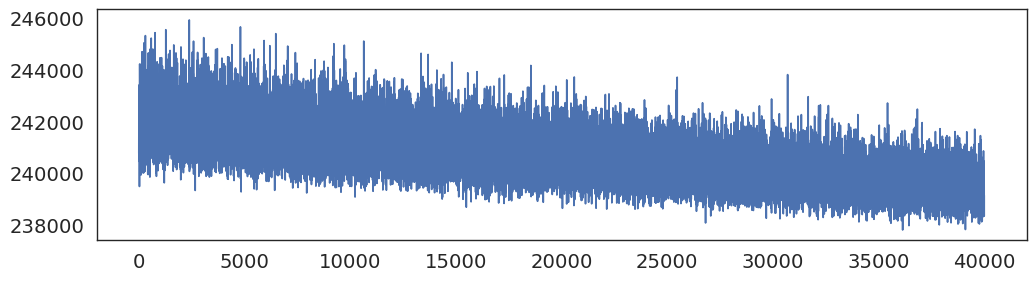

In [ ]:
output = run_inference(rng_key, lenet, opts_regression, opts_fitting, cif10_train_ds, cif10_test_ds, reg_model=SVIRegression)
results_cifar10['Flat-MAP'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])
jnp.savez('tmp_cifar10_results.npz', results=results_cifar10)

100%|██████████| 10/10 [25:20<00:00, 152.02s/it, init loss: 2806548.7500, avg. loss [epoch 10]: 58265.4922]


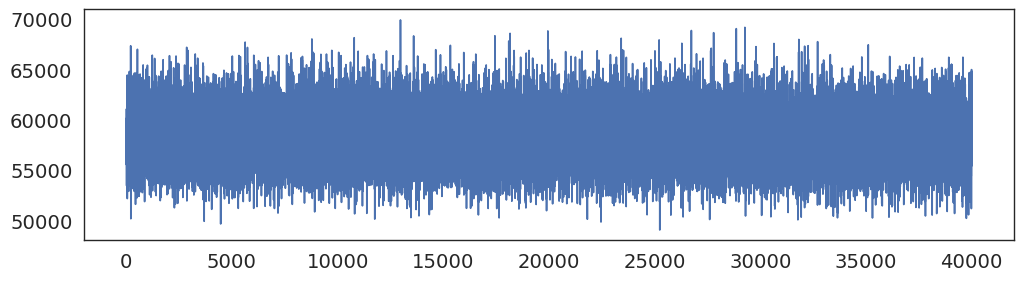

In [ ]:
opts_regression = opts_regression | {'autoguide': 'mean-field', 'optim_kwargs': {'learning_rate': 1e-3}}
opts_fitting['num_samples'] = 100

output = run_inference(rng_key, lenet, opts_regression, opts_fitting, cif10_train_ds, cif10_test_ds, reg_model=SVIRegression)
results_cifar10['Flat-FF'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])
jnp.savez('tmp_cifar10_results.npz', results=results_cifar10)

100%|██████████| 10/10 [42:06<00:00, 252.70s/it, init loss: 2807194.2500, avg. loss [epoch 10]: 54508.2812]


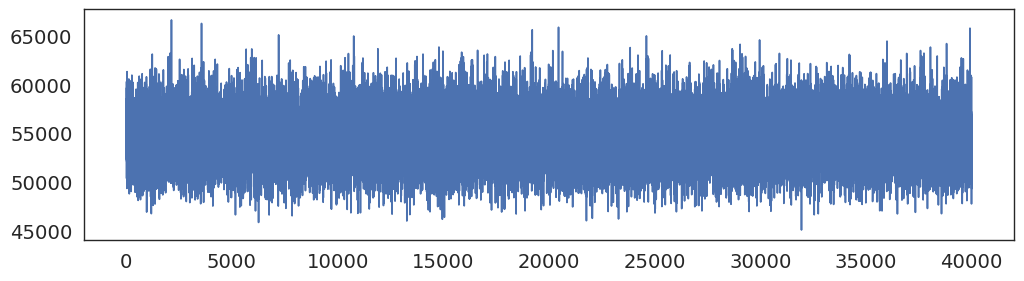

In [ ]:
opts_regression = opts_regression | {'autoguide': 'structured'}

output = run_inference(rng_key, lenet, opts_regression, opts_fitting, cif10_train_ds, cif10_test_ds, reg_model=SVIRegression)
results_cifar10['Flat-STR'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])
jnp.savez('tmp_cifar10_results.npz', results=results_cifar10)

100%|██████████| 10/10 [24:38<00:00, 147.83s/it, init loss: 582286.5625, avg. loss [epoch 10]: 58569.2930]


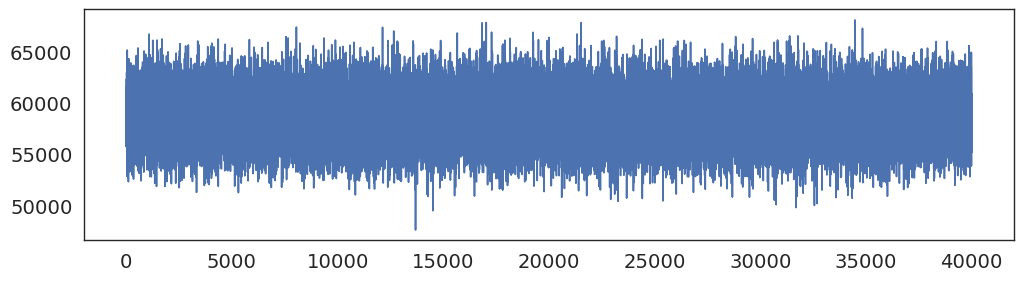

In [ ]:
opts_regression = opts_regression | {'posterior': 'normal', 'optim_kwargs': {'learning_rate': 1e-3}}
opts_fitting['num_samples'] = 100

output = run_inference(rng_key, lenet, opts_regression, opts_fitting, cif10_train_ds, cif10_test_ds, reg_model=BMRRegression)
results_cifar10['BMR-S&S'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])
jnp.savez('tmp_cifar10_results.npz', results=results_cifar10)

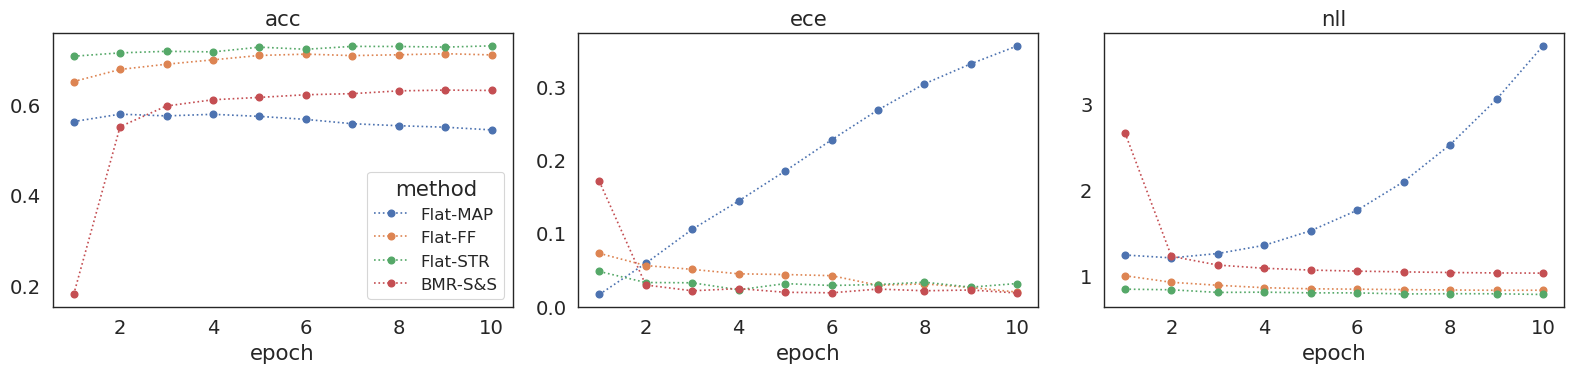

In [ ]:
fig = plot_performance(results_cifar10);

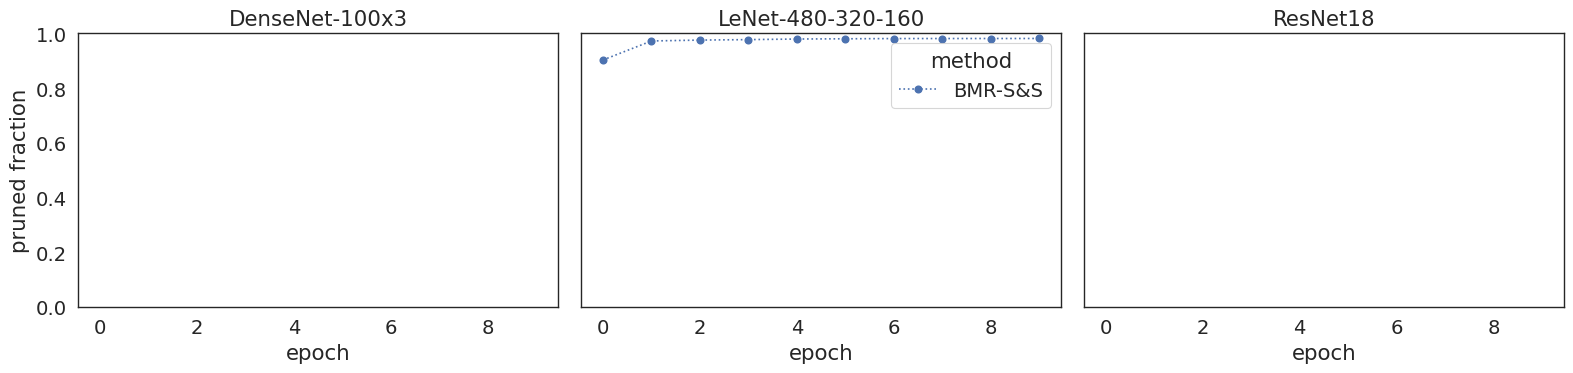

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharex=True, sharey=True)

for key in results_cifar10:
    vals = results_cifar10[key]
    try:
        axes[1].plot(range(num_epochs), vals['zip'], 'o:', label=key)
    except:
        pass

for ax in axes:
    ax.set_xlabel('epoch')

axes[0].set_ylabel('pruned fraction')
axes[0].set_ylim([0, 1])
axes[0].set_title('DenseNet-100x3')
axes[1].set_title('LeNet-480-320-160')
axes[2].set_title('ResNet18')


axes[1].legend(title='method')
fig.tight_layout()

# CIFAR100

(3, 36, 36) 100


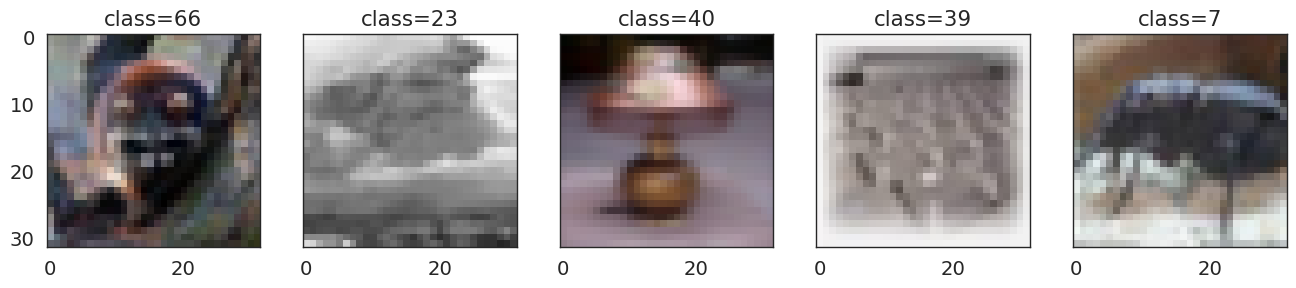

In [ ]:
# load data
cif100_train_ds, cif100_test_ds = load_data('cifar100', platform='gpu', id=0)

in_size_cif100 = cif100_train_ds['image'].shape[-3:]
out_size_cif100 = len(jnp.unique(cif100_train_ds['label']))

fig, axes = plt.subplots(1, 5, figsize=(16, 3), sharex=True, sharey=True)
for n in range(5):
    axes[n].imshow(cif100_train_ds['image'][n]/255)
    axes[n].set_title('class={}'.format(cif100_train_ds['label'][n]))

cif100_train_ds['image'], cif100_test_ds['image'] = standardize(cif100_train_ds['image'], cif100_test_ds['image'], num_channels=3)

cif100_train_ds['image'] = jnp.pad(cif100_train_ds['image'].transpose(0, 3, 1, 2), ((0, 0), (0, 0), (2, 2), (2, 2)))
cif100_test_ds['image'] = jnp.pad(cif100_test_ds['image'].transpose(0, 3, 1, 2), ((0, 0), (0, 0), (2, 2), (2, 2)))

in_size_cif100 = cif100_train_ds['image'].shape[-3:]
out_size_cif100 = len(jnp.unique(cif100_train_ds['label']))

print(in_size_cif100, out_size_cif100)

In [ ]:
try:
    results_cifar100 = jnp.load('tmp_cifar100_results.npz', allow_pickle=True)['results'].item()
except:
    results_cifar100 = {
        'Flat-MAP': None, 
        'Flat-FF': None, 
        'Flat-STR': None,
        'Tiered-FF': None,
        'Tiered-STR': None,
        'BMR-S&S': None,
        'BMR-RHS': None
        }

num_epochs = 5
num_iters = 80_000

opts_regression = {
    'regtype': 'multinomial',
    'gamma0': 0.1,
    'autoguide': 'delta',
    'optim_kwargs': {
        'learning_rate': 1e-4
    }
}

opts_fitting = {
    'num_epochs': num_epochs,
    'num_iters': num_iters,
    'num_samples': 1,
    'model_kwargs': {
        'batch_size': 512, 
        'with_hyperprior': False,
    }
}

rng_key, key = random.split(rng_key)
lenet = LeNet(in_size_cif100, conv_features=[12, 32, 240], dense_features=[320, 160, out_size_cif100], key=key)

100%|██████████| 5/5 [13:24<00:00, 160.99s/it, init loss: 793026.7500, avg. loss [epoch 5]: 555713.9375]


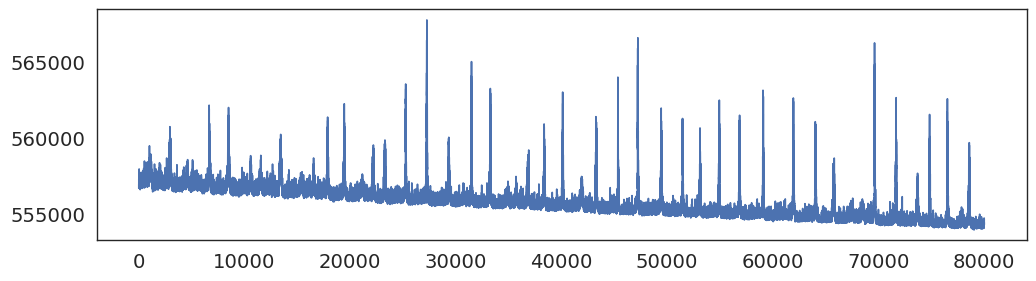

In [ ]:
output = run_inference(rng_key, lenet, opts_regression, opts_fitting, cif100_train_ds, cif100_test_ds, reg_model=SVIRegression)
results_cifar100['Flat-MAP'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])
jnp.savez('tmp_cifar100_results.npz', results=results_cifar100)

100%|██████████| 5/5 [54:26<00:00, 653.27s/it, init loss: 13393188.0000, avg. loss [epoch 5]: 166868.4219]


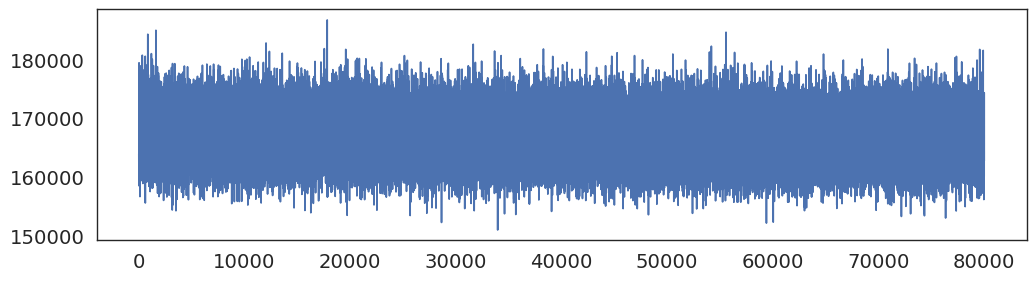

In [ ]:
opts_regression = opts_regression | {'autoguide': 'mean-field', 'optim_kwargs': {'learning_rate': 1e-3}}
opts_fitting['num_samples'] = 100

output = run_inference(rng_key, lenet, opts_regression, opts_fitting, cif100_train_ds, cif100_test_ds, reg_model=SVIRegression)
results_cifar100['Flat-FF'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])
jnp.savez('tmp_cifar100_results.npz', results=results_cifar100)

100%|██████████| 5/5 [1:19:47<00:00, 957.46s/it, init loss: 7541872.5000, avg. loss [epoch 5]: 148271.1094]


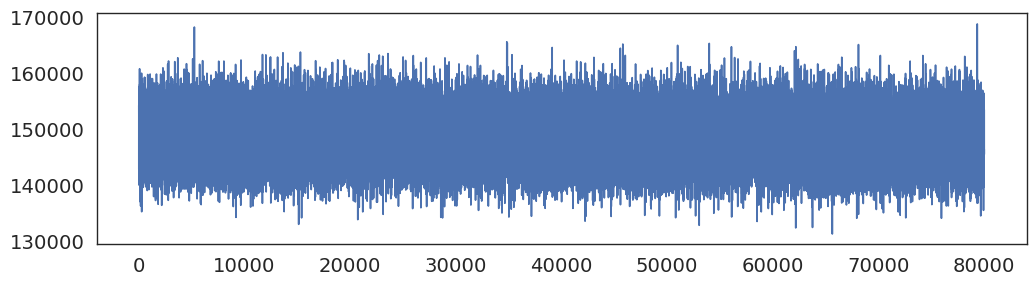

In [ ]:
opts_regression = opts_regression | {'autoguide': 'structured', 'optim_kwargs': {'learning_rate': 1e-3}}
opts_fitting['num_samples'] = 100

output = run_inference(rng_key, lenet, opts_regression, opts_fitting, cif100_train_ds, cif100_test_ds, reg_model=SVIRegression)
results_cifar100['Flat-STR'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])
jnp.savez('tmp_cifar100_results.npz', results=results_cifar100)

100%|██████████| 5/5 [55:34<00:00, 666.92s/it, init loss: 1278408.5000, avg. loss [epoch 5]: 158951.5625]


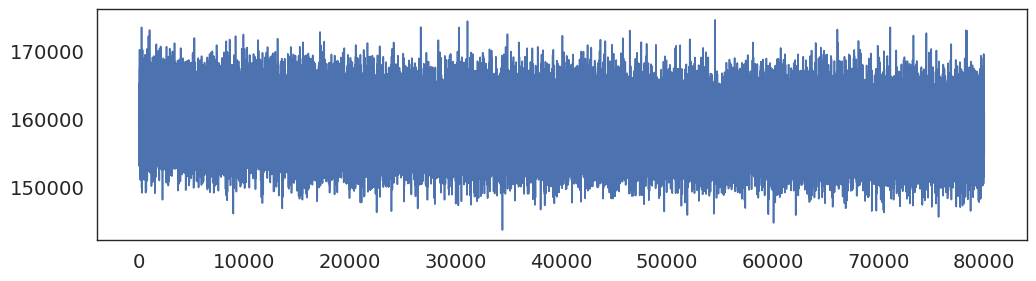

In [ ]:
opts_regression = opts_regression | {'posterior': 'normal', 'optim_kwargs': {'learning_rate': 1e-3}}
opts_fitting['num_samples'] = 100

output = run_inference(rng_key, lenet, opts_regression, opts_fitting, cif100_train_ds, cif100_test_ds, reg_model=BMRRegression)
results_cifar100['BMR-S&S'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])
jnp.savez('tmp_cifar100_results.npz', results=results_cifar100)

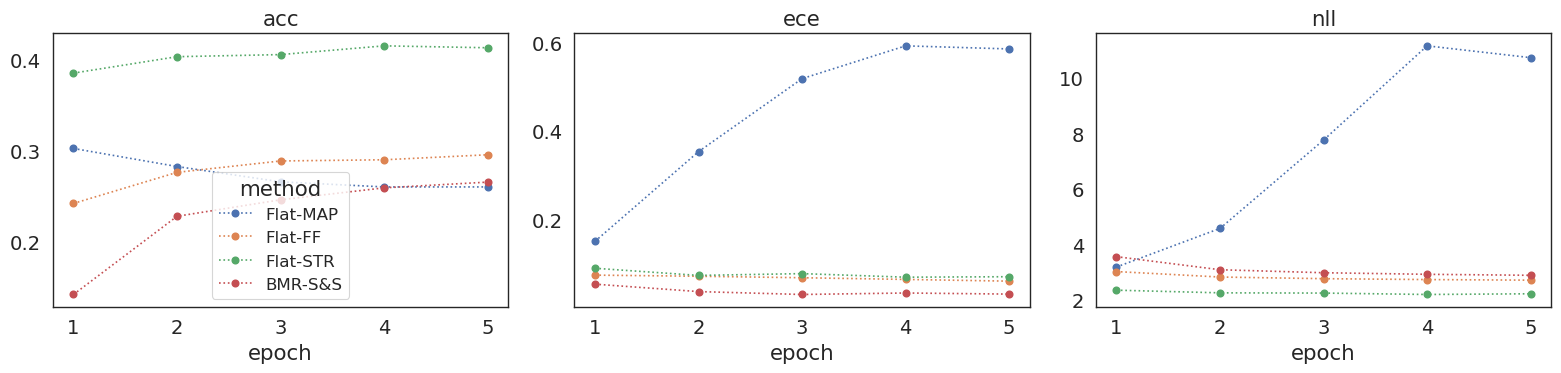

In [ ]:
fig = plot_performance(results_cifar100);